# 2nd Course: Classifying and Matching Digits

In this notebook we have a look at `tf.keras`, the high-level API of TensorFlow for building and training neural networks.

In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')


## Step 1: Loading the MNIST dataset as a `tf.data.Dataset`

We use the MNIST dataset of images of hand-written digits:

In [15]:
import tensorflow_datasets as tdfs

tdfs.disable_progress_bar()

mnist_train = tdfs.load(name='mnist', split='train')
mnist_test = tdfs.load(name='mnist', split='test')

mnist_train, mnist_test

(<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 <DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>)

Let us have a look at the first three images:

Label: 4


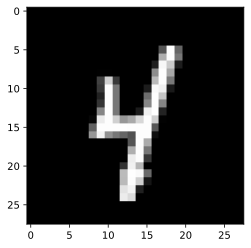

In [16]:
import matplotlib.pyplot as plt

GRAY_CMAP = plt.get_cmap('gray')

for sample in mnist_train.take(1):  # Only take a single example
    image, label = sample["image"], sample["label"]
    print(f'Label: {label}')
    plt.imshow(image[:, :, 0], cmap=GRAY_CMAP)
    plt.show()


## Step 2: Preprocessing for classification


Our first aim is to classify the digits using a neural network. We therefore

- scale the image tensor so that the greyscale values are between 0 and 1, and
- one-hot-encode the labels:


In [43]:
eye = tf.eye(10, dtype='float32') # identity matrix of size 10x10

def scale_ohe(sample):
    scaled_image = tf.cast(sample['image'], 'float32') / tf.constant(255, 'float32')
    ohe_label = eye[tf.cast(sample['label'], 'int32')]
    return scaled_image,  ohe_label

Xy_train = mnist_train.map(scale_ohe)
Xy_test = mnist_test.map(scale_ohe)

print([(image.shape, label) for image, label  in Xy_train.take(4)])

[(TensorShape([28, 28, 1]), <tf.Tensor: id=1564, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)>), (TensorShape([28, 28, 1]), <tf.Tensor: id=1566, shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (TensorShape([28, 28, 1]), <tf.Tensor: id=1568, shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (TensorShape([28, 28, 1]), <tf.Tensor: id=1570, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>)]


To make the task more interesting, we'll add some noise to the digits:

In [44]:
NOISE_STDDEV = 0.3
noise = tf.data.Dataset.range(1).repeat().map(lambda _: tf.random.normal((28,28,1), 0.5, NOISE_STDDEV))


In [55]:
def add_noise(image, label):
    return image + tf.random.normal(image.shape, 0, NOISE_STDDEV), label

Xy_noisy_train = Xy_train.map(add_noise, 1) # don't leave out 1 here!
Xy_noisy_test = Xy_test.map(add_noise, 1) # don't leave out 1 here!


Let's check what the images look like now:

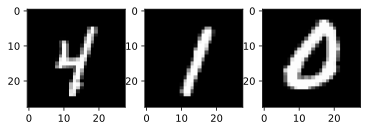

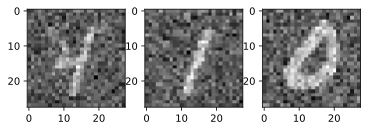

In [56]:
def show_images(dataset, nr_samples=3):
    _, axes = plt.subplots(1, nr_samples)
    for i, sample in enumerate(dataset.take(nr_samples)):
        axes[i].imshow(sample[0][:,:,0], cmap=GRAY_CMAP)
    plt.show()

show_images(Xy_train)
show_images(Xy_noisy_train)

## Step 3:  Building and training a sequential model

Let us build and train a neural network to classify the digits.

First, we build it as a sequential model, that is, as a stack of layers:

In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Next, we specify how the model should learn, that is,

- which loss function should be optimized and
- which optimizer should be used.

Additionally, we declare a metrics that should be watched during training.

In [66]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

Finally, we train the model, and obtain a training history that we plot:

Epoch 1/5
      1/Unknown - 0s 55ms/step - loss: 0.0640 - accuracy: 1.0000

      2/Unknown - 0s 29ms/step - loss: 0.1140 - accuracy: 0.9688

      3/Unknown - 0s 20ms/step - loss: 0.1066 - accuracy: 0.9688

      4/Unknown - 0s 15ms/step - loss: 0.1272 - accuracy: 0.9688

      5/Unknown - 0s 13ms/step - loss: 0.1203 - accuracy: 0.9688

      6/Unknown - 0s 11ms/step - loss: 0.1629 - accuracy: 0.9635

      7/Unknown - 0s 10ms/step - loss: 0.1633 - accuracy: 0.9598

      8/Unknown - 0s 9ms/step - loss: 0.1618 - accuracy: 0.9531 

      9/Unknown - 0s 8ms/step - loss: 0.1578 - accuracy: 0.9549

     10/Unknown - 0s 8ms/step - loss: 0.1598 - accuracy: 0.9563

     11/Unknown - 0s 7ms/step - loss: 0.1627 - accuracy: 0.9517

     12/Unknown - 0s 7ms/step - loss: 0.1589 - accuracy: 0.9557

     13/Unknown - 0s 6ms/step - loss: 0.1633 - accuracy: 0.9471

     14/Unknown - 0s 6ms/step - loss: 0.1644 - accuracy: 0.9464

     15/Unknown - 0s 6ms/step - loss: 0.1771 - accuracy: 0.9417

     16/Unknown - 0s 6ms/step - loss: 0.1683 - accuracy: 0.9453

     17/Unknown - 0s 5ms/step - loss: 0.1668 - accuracy: 0.9467

     18/Unknown - 0s 5ms/step - loss: 0.1688 - accuracy: 0.9444

     19/Unknown - 0s 5ms/step - loss: 0.1802 - accuracy: 0.9375

     20/Unknown - 0s 5ms/step - loss: 0.1801 - accuracy: 0.9375

     21/Unknown - 0s 5ms/step - loss: 0.1800 - accuracy: 0.9375

     22/Unknown - 0s 5ms/step - loss: 0.1820 - accuracy: 0.9361

     23/Unknown - 0s 4ms/step - loss: 0.1838 - accuracy: 0.9361

     24/Unknown - 0s 4ms/step - loss: 0.1916 - accuracy: 0.9362

     25/Unknown - 0s 4ms/step - loss: 0.1908 - accuracy: 0.9375

     26/Unknown - 0s 4ms/step - loss: 0.1930 - accuracy: 0.9363

     27/Unknown - 0s 4ms/step - loss: 0.1899 - accuracy: 0.9375

     28/Unknown - 0s 4ms/step - loss: 0.1909 - accuracy: 0.9375

     29/Unknown - 0s 4ms/step - loss: 0.1928 - accuracy: 0.9386

     30/Unknown - 0s 4ms/step - loss: 0.1906 - accuracy: 0.9396

     31/Unknown - 0s 4ms/step - loss: 0.1956 - accuracy: 0.9345

     32/Unknown - 0s 4ms/step - loss: 0.1985 - accuracy: 0.9336

     33/Unknown - 0s 4ms/step - loss: 0.2001 - accuracy: 0.9337

     34/Unknown - 0s 4ms/step - loss: 0.1976 - accuracy: 0.9347

     35/Unknown - 0s 4ms/step - loss: 0.1997 - accuracy: 0.9330

     36/Unknown - 0s 4ms/step - loss: 0.2007 - accuracy: 0.9314

     37/Unknown - 0s 4ms/step - loss: 0.2011 - accuracy: 0.9316

     38/Unknown - 0s 4ms/step - loss: 0.2006 - accuracy: 0.9326

     39/Unknown - 0s 4ms/step - loss: 0.1969 - accuracy: 0.9343

     40/Unknown - 0s 3ms/step - loss: 0.1988 - accuracy: 0.9320

     41/Unknown - 0s 3ms/step - loss: 0.1979 - accuracy: 0.9329

     42/Unknown - 0s 3ms/step - loss: 0.1984 - accuracy: 0.9315

     43/Unknown - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9324

     44/Unknown - 0s 3ms/step - loss: 0.1940 - accuracy: 0.9339

     45/Unknown - 0s 3ms/step - loss: 0.1962 - accuracy: 0.9326

     46/Unknown - 0s 3ms/step - loss: 0.1997 - accuracy: 0.9314

     47/Unknown - 0s 3ms/step - loss: 0.1981 - accuracy: 0.9322

     48/Unknown - 0s 3ms/step - loss: 0.1964 - accuracy: 0.9329

     49/Unknown - 0s 3ms/step - loss: 0.1987 - accuracy: 0.9324

     50/Unknown - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9337

     51/Unknown - 0s 3ms/step - loss: 0.1949 - accuracy: 0.9344

     52/Unknown - 0s 3ms/step - loss: 0.1967 - accuracy: 0.9339

     53/Unknown - 0s 3ms/step - loss: 0.1945 - accuracy: 0.9346

     54/Unknown - 0s 3ms/step - loss: 0.1939 - accuracy: 0.9346

     55/Unknown - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9347

     56/Unknown - 0s 3ms/step - loss: 0.2073 - accuracy: 0.9330

     57/Unknown - 0s 3ms/step - loss: 0.2077 - accuracy: 0.9331

     58/Unknown - 0s 3ms/step - loss: 0.2137 - accuracy: 0.9321

     59/Unknown - 0s 3ms/step - loss: 0.2145 - accuracy: 0.9317

     60/Unknown - 0s 3ms/step - loss: 0.2142 - accuracy: 0.9318

     61/Unknown - 0s 3ms/step - loss: 0.2128 - accuracy: 0.9324

     62/Unknown - 0s 3ms/step - loss: 0.2107 - accuracy: 0.9335

     63/Unknown - 0s 3ms/step - loss: 0.2159 - accuracy: 0.9325

     64/Unknown - 0s 3ms/step - loss: 0.2154 - accuracy: 0.9326

     65/Unknown - 0s 3ms/step - loss: 0.2131 - accuracy: 0.9337

     66/Unknown - 0s 3ms/step - loss: 0.2118 - accuracy: 0.9347

     67/Unknown - 0s 3ms/step - loss: 0.2099 - accuracy: 0.9352

     68/Unknown - 0s 3ms/step - loss: 0.2110 - accuracy: 0.9352

     69/Unknown - 0s 3ms/step - loss: 0.2105 - accuracy: 0.9352

     70/Unknown - 0s 3ms/step - loss: 0.2106 - accuracy: 0.9348

     71/Unknown - 0s 3ms/step - loss: 0.2138 - accuracy: 0.9340

     72/Unknown - 0s 3ms/step - loss: 0.2155 - accuracy: 0.9332

     73/Unknown - 0s 3ms/step - loss: 0.2176 - accuracy: 0.9324

     74/Unknown - 0s 3ms/step - loss: 0.2179 - accuracy: 0.9324

     75/Unknown - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9333

     76/Unknown - 0s 3ms/step - loss: 0.2183 - accuracy: 0.9330

     77/Unknown - 0s 3ms/step - loss: 0.2176 - accuracy: 0.9330

     78/Unknown - 0s 3ms/step - loss: 0.2173 - accuracy: 0.9327

     79/Unknown - 0s 3ms/step - loss: 0.2157 - accuracy: 0.9335

     80/Unknown - 0s 3ms/step - loss: 0.2163 - accuracy: 0.9332

     81/Unknown - 0s 3ms/step - loss: 0.2163 - accuracy: 0.9333

     82/Unknown - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9341

     83/Unknown - 0s 3ms/step - loss: 0.2170 - accuracy: 0.9341

     84/Unknown - 0s 3ms/step - loss: 0.2167 - accuracy: 0.9342

     85/Unknown - 0s 3ms/step - loss: 0.2164 - accuracy: 0.9342

     86/Unknown - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9335

     87/Unknown - 0s 3ms/step - loss: 0.2180 - accuracy: 0.9328

     88/Unknown - 0s 3ms/step - loss: 0.2192 - accuracy: 0.9325

     89/Unknown - 0s 3ms/step - loss: 0.2190 - accuracy: 0.9322

     90/Unknown - 0s 3ms/step - loss: 0.2179 - accuracy: 0.9326

     91/Unknown - 0s 3ms/step - loss: 0.2170 - accuracy: 0.9334

     92/Unknown - 0s 3ms/step - loss: 0.2182 - accuracy: 0.9334

     93/Unknown - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9321

     94/Unknown - 0s 3ms/step - loss: 0.2280 - accuracy: 0.9318

     95/Unknown - 0s 3ms/step - loss: 0.2281 - accuracy: 0.9319

     96/Unknown - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9316

     97/Unknown - 0s 3ms/step - loss: 0.2311 - accuracy: 0.9307

     98/Unknown - 0s 3ms/step - loss: 0.2310 - accuracy: 0.9302

     99/Unknown - 0s 3ms/step - loss: 0.2344 - accuracy: 0.9283

    100/Unknown - 0s 3ms/step - loss: 0.2350 - accuracy: 0.9281

    101/Unknown - 0s 3ms/step - loss: 0.2369 - accuracy: 0.9279

    102/Unknown - 0s 3ms/step - loss: 0.2395 - accuracy: 0.9274

    103/Unknown - 0s 3ms/step - loss: 0.2390 - accuracy: 0.9272

    104/Unknown - 0s 3ms/step - loss: 0.2385 - accuracy: 0.9273

    105/Unknown - 0s 3ms/step - loss: 0.2406 - accuracy: 0.9265

    106/Unknown - 0s 3ms/step - loss: 0.2435 - accuracy: 0.9248

    107/Unknown - 0s 3ms/step - loss: 0.2460 - accuracy: 0.9241

    108/Unknown - 0s 3ms/step - loss: 0.2464 - accuracy: 0.9242

    109/Unknown - 0s 3ms/step - loss: 0.2449 - accuracy: 0.9249

    110/Unknown - 0s 3ms/step - loss: 0.2449 - accuracy: 0.9250

    111/Unknown - 0s 3ms/step - loss: 0.2446 - accuracy: 0.9251

    112/Unknown - 0s 3ms/step - loss: 0.2449 - accuracy: 0.9249

    113/Unknown - 0s 3ms/step - loss: 0.2456 - accuracy: 0.9251

    114/Unknown - 0s 3ms/step - loss: 0.2440 - accuracy: 0.9257

    115/Unknown - 0s 3ms/step - loss: 0.2449 - accuracy: 0.9253

    116/Unknown - 0s 3ms/step - loss: 0.2453 - accuracy: 0.9251

    117/Unknown - 0s 3ms/step - loss: 0.2454 - accuracy: 0.9252

    118/Unknown - 0s 2ms/step - loss: 0.2469 - accuracy: 0.9256

    119/Unknown - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9259

    120/Unknown - 0s 2ms/step - loss: 0.2453 - accuracy: 0.9258

    121/Unknown - 0s 2ms/step - loss: 0.2446 - accuracy: 0.9259

    122/Unknown - 0s 2ms/step - loss: 0.2436 - accuracy: 0.9262

    123/Unknown - 0s 2ms/step - loss: 0.2446 - accuracy: 0.9261

    124/Unknown - 0s 2ms/step - loss: 0.2438 - accuracy: 0.9264

    125/Unknown - 0s 2ms/step - loss: 0.2436 - accuracy: 0.9265

    126/Unknown - 0s 2ms/step - loss: 0.2435 - accuracy: 0.9266

    127/Unknown - 0s 2ms/step - loss: 0.2429 - accuracy: 0.9269

    128/Unknown - 0s 2ms/step - loss: 0.2445 - accuracy: 0.9263

    129/Unknown - 0s 2ms/step - loss: 0.2443 - accuracy: 0.9264

    130/Unknown - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9262

    131/Unknown - 0s 2ms/step - loss: 0.2435 - accuracy: 0.9268

    132/Unknown - 0s 2ms/step - loss: 0.2428 - accuracy: 0.9268

    133/Unknown - 0s 2ms/step - loss: 0.2431 - accuracy: 0.9267

    134/Unknown - 0s 2ms/step - loss: 0.2422 - accuracy: 0.9270

    135/Unknown - 0s 2ms/step - loss: 0.2425 - accuracy: 0.9269

    136/Unknown - 0s 2ms/step - loss: 0.2427 - accuracy: 0.9267

    137/Unknown - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9272

    138/Unknown - 0s 2ms/step - loss: 0.2409 - accuracy: 0.9275

    139/Unknown - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9272

    140/Unknown - 0s 2ms/step - loss: 0.2414 - accuracy: 0.9275

    141/Unknown - 0s 2ms/step - loss: 0.2404 - accuracy: 0.9277

    142/Unknown - 0s 2ms/step - loss: 0.2401 - accuracy: 0.9276

    143/Unknown - 0s 2ms/step - loss: 0.2400 - accuracy: 0.9279

    144/Unknown - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9282

    145/Unknown - 0s 2ms/step - loss: 0.2385 - accuracy: 0.9284

    146/Unknown - 0s 2ms/step - loss: 0.2394 - accuracy: 0.9285

    147/Unknown - 0s 2ms/step - loss: 0.2401 - accuracy: 0.9286

    148/Unknown - 0s 2ms/step - loss: 0.2403 - accuracy: 0.9284

    149/Unknown - 0s 2ms/step - loss: 0.2403 - accuracy: 0.9283

    150/Unknown - 0s 2ms/step - loss: 0.2405 - accuracy: 0.9281

    151/Unknown - 0s 2ms/step - loss: 0.2417 - accuracy: 0.9276

    152/Unknown - 0s 2ms/step - loss: 0.2435 - accuracy: 0.9270

    153/Unknown - 0s 2ms/step - loss: 0.2426 - accuracy: 0.9275

    154/Unknown - 0s 2ms/step - loss: 0.2452 - accuracy: 0.9272

    155/Unknown - 0s 2ms/step - loss: 0.2448 - accuracy: 0.9274

    156/Unknown - 0s 2ms/step - loss: 0.2448 - accuracy: 0.9271

    157/Unknown - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9271

    158/Unknown - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9268

    159/Unknown - 0s 2ms/step - loss: 0.2451 - accuracy: 0.9267

    160/Unknown - 0s 2ms/step - loss: 0.2457 - accuracy: 0.9268

    161/Unknown - 0s 2ms/step - loss: 0.2463 - accuracy: 0.9262

    162/Unknown - 0s 2ms/step - loss: 0.2470 - accuracy: 0.9263

    163/Unknown - 0s 2ms/step - loss: 0.2482 - accuracy: 0.9262

    164/Unknown - 0s 2ms/step - loss: 0.2476 - accuracy: 0.9263

    165/Unknown - 0s 2ms/step - loss: 0.2481 - accuracy: 0.9263

    166/Unknown - 0s 2ms/step - loss: 0.2482 - accuracy: 0.9264

    167/Unknown - 0s 2ms/step - loss: 0.2476 - accuracy: 0.9265

    168/Unknown - 0s 2ms/step - loss: 0.2471 - accuracy: 0.9265

    169/Unknown - 0s 2ms/step - loss: 0.2464 - accuracy: 0.9268

    170/Unknown - 0s 2ms/step - loss: 0.2468 - accuracy: 0.9270

    171/Unknown - 0s 2ms/step - loss: 0.2484 - accuracy: 0.9273

    172/Unknown - 0s 2ms/step - loss: 0.2481 - accuracy: 0.9273

    173/Unknown - 0s 2ms/step - loss: 0.2484 - accuracy: 0.9268

    174/Unknown - 0s 2ms/step - loss: 0.2474 - accuracy: 0.9273

    175/Unknown - 0s 2ms/step - loss: 0.2483 - accuracy: 0.9271

    176/Unknown - 0s 2ms/step - loss: 0.2502 - accuracy: 0.9267

    177/Unknown - 0s 2ms/step - loss: 0.2494 - accuracy: 0.9271

    178/Unknown - 0s 2ms/step - loss: 0.2487 - accuracy: 0.9275

    179/Unknown - 0s 2ms/step - loss: 0.2481 - accuracy: 0.9275

    180/Unknown - 0s 2ms/step - loss: 0.2486 - accuracy: 0.9276

    181/Unknown - 0s 2ms/step - loss: 0.2478 - accuracy: 0.9277

    182/Unknown - 0s 2ms/step - loss: 0.2481 - accuracy: 0.9274

    183/Unknown - 0s 2ms/step - loss: 0.2478 - accuracy: 0.9274

    184/Unknown - 0s 2ms/step - loss: 0.2493 - accuracy: 0.9275

    185/Unknown - 0s 2ms/step - loss: 0.2488 - accuracy: 0.9275

    186/Unknown - 0s 2ms/step - loss: 0.2488 - accuracy: 0.9274

    187/Unknown - 0s 2ms/step - loss: 0.2480 - accuracy: 0.9278

    188/Unknown - 0s 2ms/step - loss: 0.2483 - accuracy: 0.9279

    189/Unknown - 0s 2ms/step - loss: 0.2479 - accuracy: 0.9279

    190/Unknown - 0s 2ms/step - loss: 0.2489 - accuracy: 0.9276

    191/Unknown - 0s 2ms/step - loss: 0.2486 - accuracy: 0.9277

    192/Unknown - 0s 2ms/step - loss: 0.2481 - accuracy: 0.9277

    193/Unknown - 0s 2ms/step - loss: 0.2478 - accuracy: 0.9278

    194/Unknown - 0s 2ms/step - loss: 0.2503 - accuracy: 0.9278

    195/Unknown - 0s 2ms/step - loss: 0.2501 - accuracy: 0.9280

    196/Unknown - 0s 2ms/step - loss: 0.2505 - accuracy: 0.9279

    197/Unknown - 0s 2ms/step - loss: 0.2505 - accuracy: 0.9281

    198/Unknown - 0s 2ms/step - loss: 0.2501 - accuracy: 0.9282

    199/Unknown - 0s 2ms/step - loss: 0.2508 - accuracy: 0.9279

    200/Unknown - 0s 2ms/step - loss: 0.2504 - accuracy: 0.9280

200/200 [==============================] - 1s 3ms/step - loss: 0.2504 - accuracy: 0.9280 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


Epoch 2/5


  1/100 [..............................] - ETA: 4s - loss: 0.0612 - accuracy: 1.0000

 42/100 [===========>..................] - ETA: 0s - loss: 0.1871 - accuracy: 0.9397

 86/100 [========================>.....] - ETA: 0s - loss: 0.2054 - accuracy: 0.9382

200/200 [==============================] - 0s 2ms/step - loss: 0.2297 - accuracy: 0.9320 - val_loss: 0.2789 - val_accuracy: 0.9259


Epoch 3/5
  1/100 [..............................] - ETA: 5s - loss: 0.0628 - accuracy: 1.0000

 44/100 [============>.................] - ETA: 0s - loss: 0.1762 - accuracy: 0.9446

 86/100 [========================>.....] - ETA: 0s - loss: 0.1974 - accuracy: 0.9393

200/200 [==============================] - 0s 2ms/step - loss: 0.2209 - accuracy: 0.9342 - val_loss: 0.2801 - val_accuracy: 0.9253


Epoch 4/5
  1/100 [..............................] - ETA: 5s - loss: 0.0641 - accuracy: 1.0000

 42/100 [===========>..................] - ETA: 0s - loss: 0.1752 - accuracy: 0.9464

 85/100 [========================>.....] - ETA: 0s - loss: 0.1907 - accuracy: 0.9441

200/200 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9370 - val_loss: 0.2816 - val_accuracy: 0.9234


Epoch 5/5
  1/100 [..............................] - ETA: 5s - loss: 0.0652 - accuracy: 1.0000

 41/100 [===========>..................] - ETA: 0s - loss: 0.1706 - accuracy: 0.9512

 83/100 [=======================>......] - ETA: 0s - loss: 0.1860 - accuracy: 0.9473

200/200 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9397 - val_loss: 0.2832 - val_accuracy: 0.9231


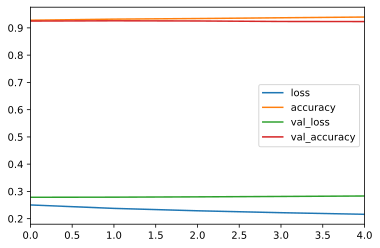

In [69]:
history = model.fit(Xy_train.batch(32).take(200), validation_data=Xy_test.batch(32).take(100), epochs=5)

def plot_history(history):
    pd.DataFrame(history.history).plot.line()

plot_history(history)

Unsurprisingly, the results are quite good already.

Before we turn to the noisy data and play around with the model, we 